In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from pathlib import Path

from sklearn.model_selection import train_test_split

from utilities.helper_functions import plot_decision_boundary

### Device agnostic

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Accuracy metrics

In [3]:
accuracy_for_training = Accuracy(task="multiclass", num_classes=3).to(device)
accuracy_for_testing = Accuracy(task="multiclass", num_classes=3).to(device)

## Generate spiral data

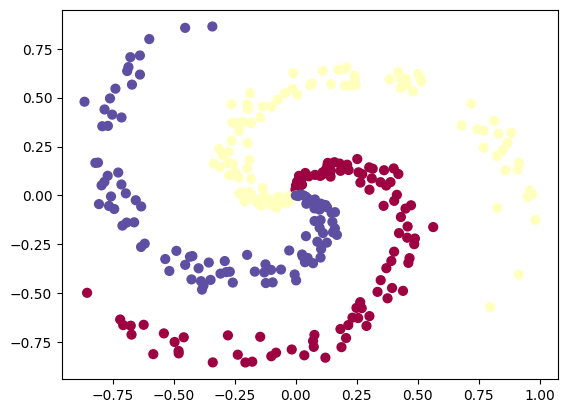

In [4]:
# Code for creating a spiral dataset from CS231n
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    random_state=42
)

len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [6]:
def numpy_to_tensor():

    global X_train, X_test, y_train, y_test

    X_train = torch.from_numpy(X_train).type(torch.float32)
    X_test = torch.from_numpy(X_test).type(torch.float32)
    y_train = torch.from_numpy(y_train).type(torch.LongTensor)
    y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [7]:
numpy_to_tensor()

In [8]:
def put_data_on(device):

    global X_train, X_test, y_train, y_test

    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)

In [9]:
print(X_train.device)
put_data_on(device)
X_train.device

cpu


device(type='cuda', index=0)

## Create model

In [10]:
class SpiralClassificationV1(nn.Module):

    def __init__(self, input_feature, output_feature, hidden_units):
        super().__init__()

        self.layer_stack = nn.Sequential(

            nn.Linear(in_features= input_feature, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features=output_feature)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:

        return self.layer_stack(x)
    
hidden_units = 30
model_0 = SpiralClassificationV1(D, K, hidden_units).to(device)
model_0

SpiralClassificationV1(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=3, bias=True)
  )
)

## Create Loss function and optimizer

In [11]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.01)

## Let's run some tests

In [12]:
logits = model_0(X_test)
preds = torch.softmax(logits, dim=1).argmax(dim=1)
loss = loss_fn(logits, y_test)
accuracy = accuracy_for_testing(preds, y_test)

logits[:5], preds[:5], y_test[:5], loss, accuracy

(tensor([[-0.1196,  0.0972, -0.1853],
         [-0.0557,  0.0430, -0.1725],
         [-0.0659,  0.0699, -0.1691],
         [-0.1147,  0.0918, -0.1817],
         [-0.1300,  0.1156, -0.1872]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([1, 1, 1, 1, 1], device='cuda:0'),
 tensor([2, 2, 1, 0, 2], device='cuda:0'),
 tensor(1.1271, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.2667, device='cuda:0'))

## Build training loop

In [13]:
def fit_fn(epochs):

    for epoch in range(epochs):

        model_0.train()

        train_logits = model_0(X_train)
        train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
        train_loss = loss_fn(train_logits, y_train)
        train_accuracy = accuracy_for_training(train_preds, y_train)

        optimizer.zero_grad()

        train_loss.backward()

        optimizer.step()

        ## 

        model_0.eval()

        with torch.inference_mode():

            test_logits = model_0(X_test)
            test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss = loss_fn(test_logits, y_test)
            test_accuracy = accuracy_for_testing(test_preds, y_test)

            if epoch % 10 == 0:

                print(f"Epoch: {epoch} --- | Train Loss: {train_loss: .5f} --- | Train Accuracy: {train_accuracy: .2f}% --- | Test Loss: {test_loss: .5f} --- | Test Accuracy: {test_accuracy: .2f}%")

In [14]:
model_0.to(device)
fit_fn(100)

Epoch: 0 --- | Train Loss:  1.10959 --- | Train Accuracy:  0.35% --- | Test Loss:  1.09952 --- | Test Accuracy:  0.27%
Epoch: 10 --- | Train Loss:  0.91722 --- | Train Accuracy:  0.64% --- | Test Loss:  0.90126 --- | Test Accuracy:  0.57%
Epoch: 20 --- | Train Loss:  0.70030 --- | Train Accuracy:  0.60% --- | Test Loss:  0.74695 --- | Test Accuracy:  0.50%
Epoch: 30 --- | Train Loss:  0.57714 --- | Train Accuracy:  0.67% --- | Test Loss:  0.61304 --- | Test Accuracy:  0.62%
Epoch: 40 --- | Train Loss:  0.45124 --- | Train Accuracy:  0.78% --- | Test Loss:  0.47142 --- | Test Accuracy:  0.75%
Epoch: 50 --- | Train Loss:  0.32868 --- | Train Accuracy:  0.88% --- | Test Loss:  0.33874 --- | Test Accuracy:  0.88%
Epoch: 60 --- | Train Loss:  0.23485 --- | Train Accuracy:  0.92% --- | Test Loss:  0.24194 --- | Test Accuracy:  0.92%
Epoch: 70 --- | Train Loss:  0.17053 --- | Train Accuracy:  0.95% --- | Test Loss:  0.17242 --- | Test Accuracy:  0.93%
Epoch: 80 --- | Train Loss:  0.12643 --- 

## Model Evaluation

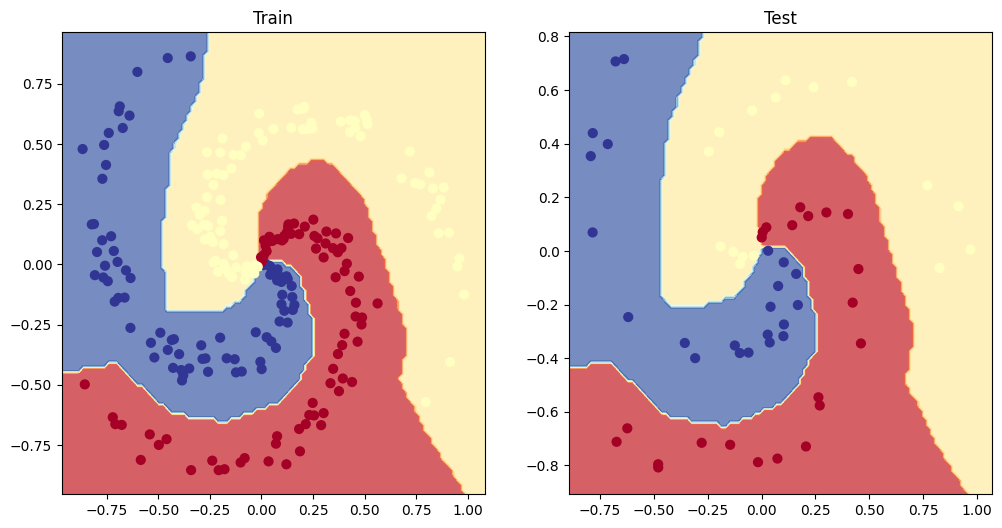

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Save model

In [16]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "05-spiral-multi-class-classification.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model at: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model at: models\05-spiral-multi-class-classification.pt


## Load model

In [17]:
loaded_model_0 = SpiralClassificationV1(D, K, hidden_units)
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

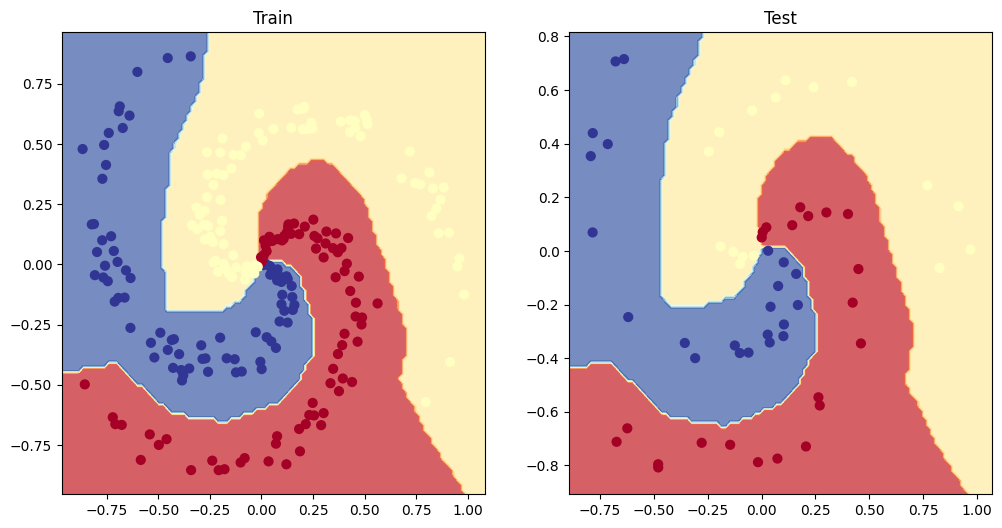

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)